In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import matplotlib.pyplot as plt 

In [4]:
gravd = pd.read_csv('/content/gdrive/MyDrive/gravity/gravd.csv')
gravd.columns

Index(['year', 'iso_o', 'iso_d', 'contig', 'comlang_off', 'distw', 'pop_o',
       'gdp_o', 'gdpcap_o', 'iso2_o', 'pop_d', 'gdp_d', 'gdpcap_d', 'iso2_d',
       'heg_d', 'conflict', 'indepdate', 'heg_o', 'col_to', 'col_fr',
       'col_hist', 'col_cur', 'sever', 'sib_conflict', 'gatt_o', 'gatt_d',
       'rta', 'comleg', 'comcur', 'acp_to_eu', 'gsp', 'eu_to_acp', 'gsp_rec',
       'flow', 'validmirror', 'family', 'isl_o', 'isl_d', 'lndl_o', 'lndl_d'],
      dtype='object')

In [6]:
gravd = gravd[['flow', 'distw'
                     , 'gdp_o', 'gdp_d'
                     , 'contig', 'comlang_off', 'col_hist'
                     , 'isl_o', 'isl_d', 'lndl_o', 'lndl_d'
                     ]]
gravd.isna().sum()

flow              0
distw             0
gdp_o          2006
gdp_d          1606
contig            0
comlang_off       0
col_hist          0
isl_o             0
isl_d             0
lndl_o            0
lndl_d            0
dtype: int64

drop nans and show correalation

In [7]:
gravd = gravd.dropna()
gravd.corr()

,flow,distw,gdp_o,gdp_d,contig,comlang_off,col_hist,isl_o,isl_d,lndl_o,lndl_d
flow,1.000000,-0.049890,0.167948,0.213254,0.148241,0.020537,0.044647,-0.004968,-0.006837,-0.028287,-0.027311
distw,-0.049890,1.000000,0.047489,0.048441,-0.206316,-0.072044,-0.043466,0.176368,0.166128,-0.091461,-0.095632
gdp_o,0.167948,0.047489,1.000000,-0.013492,-0.003589,0.002866,0.054973,0.005815,0.006266,-0.092983,0.014054
gdp_d,0.213254,0.048441,-0.013492,1.000000,-0.003612,0.002542,0.054800,0.006411,0.007017,0.011372,-0.091553
contig,0.148241,-0.206316,-0.003589,-0.003612,1.000000,0.110013,0.089646,-0.068270,-0.068126,0.037150,0.037822
comlang_off,0.020537,-0.072044,0.002866,0.002542,0.110013,1.000000,0.145083,0.117948,0.125097,-0.017339,-0.025740
col_hist,0.044647,-0.043466,0.054973,0.054800,0.089646,0.145083,1.000000,0.031037,0.031258,-0.024387,-0.023205
isl_o,-0.004968,0.176368,0.005815,0.006411,-0.068270,0.117948,0.031037,1.000000,0.019769,-0.234955,-0.015212
isl_d,-0.006837,0.166128,0.006266,0.007017,-0.068126,0.125097,0.031258,0.019769,1.000000,-0.017286,-0.230824
lndl_o,-0.028287,-0.091461,-0.092983,0.011372,0.037150,-0.017339,-0.024387,-0.234955,-0.017286,1.000000,-0.006014


sort data (only to check details on stratification)

In [8]:
# gravd = gravd.sort_values('flow', ignore_index=True)

how many zero obs are in the data

In [9]:
flow = np.array(gravd.flow.astype(np.float32))  
print('of', len(flow), 'observations'
      , len(flow) - np.count_nonzero(flow), ' are zero ='
      , (len(flow) - np.count_nonzero(flow))/ len(flow)*100, '%')


of 26967 observations 6970  are zero = 25.846404865205624 %


create bins for stratify in train-test-split

In [8]:
#len(gravd)

In [10]:
#bins = np.linspace(0, len(gravd), 20)
bins = np.geomspace(1, len(gravd), 100)
flowZ = flow.copy()
flowZ = np.digitize(flow, bins)
# flowZ[26800:26967]

reformat

In [15]:
# weighted geographical between origin and destination
distw = np.array(gravd.distw.astype(np.float32))

# GDP of origin
gdp_o = np.array(gravd.gdp_o.astype(np.float32))

# GDP of destination
gdp_d = np.array(gravd.gdp_d.astype(np.float32))

# Dummies 
# neighbourhood status between origin and destination
contig = np.array(gravd.contig.astype(np.int8))
# common official language of origin and destination
comlang_off = np.array(gravd.comlang_off.astype(np.int8))
# colonial ties between origin and destination
col_hist = np.array(gravd.col_hist.astype(np.int8))
# island
isl_o = np.array(gravd.isl_o.astype(np.int8))
isl_d = np.array(gravd.isl_d.astype(np.int8))
# landlocked
lndl_o = np.array(gravd.lndl_o.astype(np.int8))
lndl_d = np.array(gravd.lndl_d.astype(np.int8))

X = np.array([flowZ, distw, gdp_o, gdp_d
              , contig, comlang_off, col_hist
              , isl_o, isl_d, lndl_o, lndl_d
              ]).T


define class and some functions for convenience

In [12]:
# class for data preparation
class prepare_data:
    def __init__(self):
        self.X = X.copy()
        self.y = flow.copy()
        
    # train test split and transform
    def tts(self, rnd = 42):
         # train test split stratify on binary zero trade
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X[:,1:11], self.y
                                                                                , random_state=(rnd)
                                                                                , test_size=0.2
                                                                                , stratify=(self.X[:,0])
                                                                                )
        
# plot feature importance 
def plot_feature_importance(model):
    n_features = len(data.X_train[0,:])
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), feature_names) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

# random repetition loop instead of cross validation
def rnd_val(estimator, cv=100):
    all_r2_test = []
    for i in range(cv):
        data.tts(rnd=None)
        estimator.fit(data.X_train, data.y_train)
        r2_test = estimator.score(data.X_test, data.y_test)
        all_r2_test.append(r2_test)
        print('R2 test:', r2_test)
        print('R2 train', estimator.score(data.X_train, data.y_train))
    print('mean R2 test:', np.mean(all_r2_test))

# get R2 for test and train data
def get_R2s(estimator):
    print('test R2:', estimator.score(data.X_test, data.y_test))
    print('train R2:', estimator.score(data.X_train, data.y_train))
    
# plot prediction against true values
def plt_y_pred(estimator):
    y_pred = estimator.predict(data.X_test)
    # plot feature importance
    plot_feature_importance(estimator)
    plt.show()
    # plot y against y^
    plt.scatter(y_pred, data.y_test, s = 3)
    plt.xlabel('prediced trade flow from test data')
    plt.ylabel('true trade flow from test data')
    plt.title('test vs predicted trade flow')
    plt.show()
    # plot y against y^ on log axes
    plt.loglog(y_pred, data.y_test, marker = 'o', markersize = 3, linestyle = '')
    plt.xlabel('prediced trade flow from test data')
    plt.ylabel('true trade flow from test data')
    plt.title('test vs predicted trade flow on log axes')
    plt.show()
    
def plt_error_hist(estimator):
  estimator.fit(data.X_train, data.y_train)
  # out-of-sample errors
  y_pred = estimator.predict(data.X_test)
  oos_errors = data.y_test - y_pred
  plt.hist(oos_errors, bins=100, log=True)
  plt.title('out-of-sample error distribution')
  plt.show()
  # within-sample errors
  y_pred_is = estimator.predict(data.X_train)
  is_errors = data.y_train - y_pred_is
  plt.hist(is_errors, bins=100, log=True)
  plt.title('within-sample error distribution')
  plt.show()

initialize data and train-test-split

In [16]:
data = prepare_data()
data.tts()

retrieve feature names

In [18]:
feature_names = gravd.columns[1:len(X[0,:])]
feature_names

Index(['distw', 'gdp_o', 'gdp_d', 'contig', 'comlang_off', 'col_hist', 'isl_o',
       'isl_d', 'lndl_o', 'lndl_d'],
      dtype='object')

# Simple Decision Tree

test R2: 0.7395588842533327
train R2: 0.9327914104934447


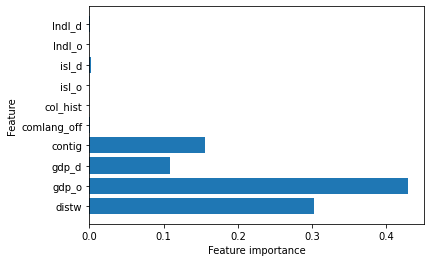

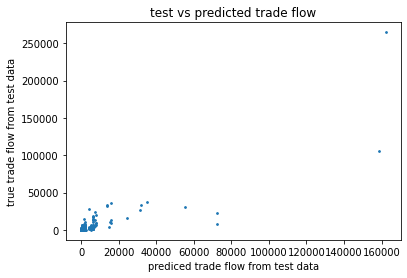

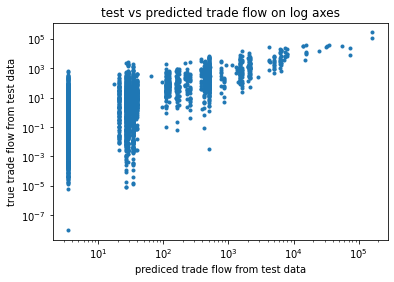

In [19]:
tree = DecisionTreeRegressor(random_state=7, max_depth=7) 
tree.fit(data.X_train, data.y_train)

get_R2s(tree)
plt_y_pred(tree)

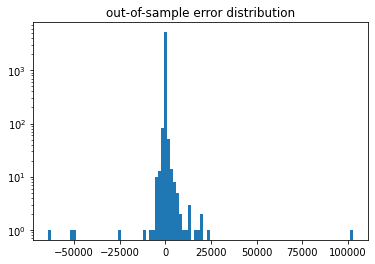

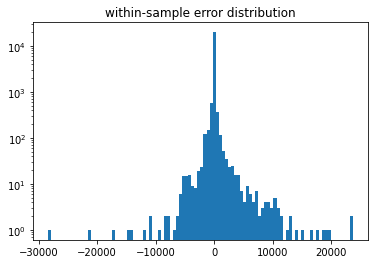

In [15]:
plt_error_hist(tree)

In [16]:
rnd_val(tree)

R2 test: 0.25840772239063037
R2 train 0.9369700567157689
R2 test: 0.555747630321515
R2 train 0.9532098738025775
R2 test: 0.4885312552454535
R2 train 0.959641670310105
R2 test: 0.7929634958116226
R2 train 0.9445550632573021
R2 test: 0.2115841762308538
R2 train 0.9414366114149916
R2 test: 0.5110732067915981
R2 train 0.9476305469962533
R2 test: 0.7759353074236
R2 train 0.944952142411143
R2 test: 0.33984530405187785
R2 train 0.9574223873505506
R2 test: 0.7093221180610587
R2 train 0.9618725000892702
R2 test: 0.7878397824187029
R2 train 0.9545943002562421
R2 test: 0.37986701535152745
R2 train 0.9614978800633198
R2 test: 0.38481206364813636
R2 train 0.9430864162886218
R2 test: 0.38018048897318213
R2 train 0.9550797885692428
R2 test: 0.2744012534146326
R2 train 0.9545788827583589
R2 test: 0.42400292699879705
R2 train 0.9521960948673994
R2 test: 0.3313819281308832
R2 train 0.9613288744931757
R2 test: 0.3649063357553868
R2 train 0.9596761086550052
R2 test: 0.18646577566401146
R2 train 0.95867706

grid search for one tree

In [17]:
# criterion
crit = ['mse', 'friedman_mse', 'poisson']

# max depth
maxD = [2, 3, 5, 8, 13, 21, 34]

# create the grid
grid = {'criterion': crit, 'max_depth': maxD}

# base model to tune
baseTree = DecisionTreeRegressor()

# random grid search for parameters
tree_grid_search = GridSearchCV(estimator = baseTree
                                , param_grid= grid
                                , cv = 7              # no of cross validation
                                , n_jobs = -1         # use all available cores
                                )

for i in range(21):
    # if grid is to run on a different data split, run this:
    data.tts(rnd = None)
    # fixed data split:
    # data.tts(rnd = 42)
    # single grid search:
    tree_grid_search.fit(data.X_train, data.y_train)
    print(tree_grid_search.best_params_)

{'criterion': 'mse', 'max_depth': 8}
{'criterion': 'mse', 'max_depth': 2}
{'criterion': 'friedman_mse', 'max_depth': 34}
{'criterion': 'mse', 'max_depth': 34}
{'criterion': 'mse', 'max_depth': 21}
{'criterion': 'friedman_mse', 'max_depth': 13}
{'criterion': 'friedman_mse', 'max_depth': 13}
{'criterion': 'friedman_mse', 'max_depth': 13}
{'criterion': 'mse', 'max_depth': 5}
{'criterion': 'mse', 'max_depth': 13}
{'criterion': 'mse', 'max_depth': 34}
{'criterion': 'mse', 'max_depth': 5}
{'criterion': 'friedman_mse', 'max_depth': 34}
{'criterion': 'friedman_mse', 'max_depth': 8}
{'criterion': 'friedman_mse', 'max_depth': 8}
{'criterion': 'mse', 'max_depth': 13}
{'criterion': 'mse', 'max_depth': 21}
{'criterion': 'friedman_mse', 'max_depth': 21}
{'criterion': 'mse', 'max_depth': 13}
{'criterion': 'friedman_mse', 'max_depth': 13}
{'criterion': 'mse', 'max_depth': 21}


# Random Forest

test R2: 0.6756121837930711
train R2: 0.9364658888028049


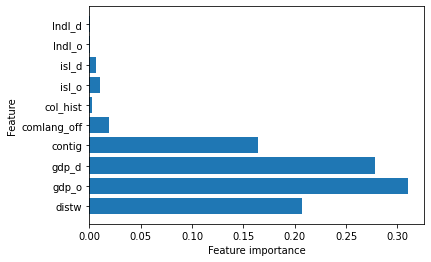

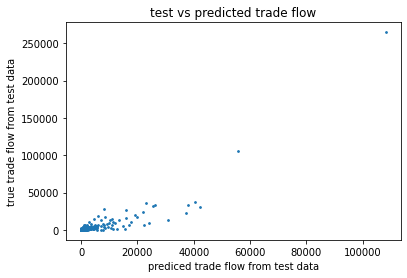

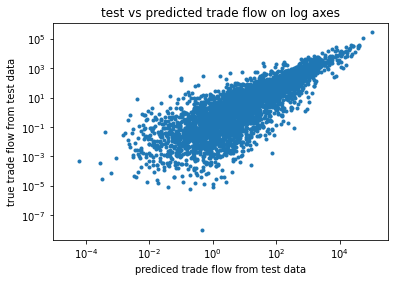

In [20]:
data.tts()
forest = RandomForestRegressor(random_state=7) 
forest.fit(data.X_train, data.y_train)

get_R2s(forest)
plt_y_pred(forest)

In [19]:
forest_opt = RandomForestRegressor(n_estimators=59, max_depth=52)
rnd_val(forest_opt)

R2 test: 0.5235098839194365
R2 train 0.9449077163606213
R2 test: 0.4574907361178712
R2 train 0.9499028539525585
R2 test: 0.6405755194068483
R2 train 0.9257831754737988
R2 test: 0.6600492650031601
R2 train 0.9397107200243169
R2 test: 0.732247813664533
R2 train 0.9415767190450841
R2 test: 0.6372144857702045
R2 train 0.9332442696764701
R2 test: 0.6899139498375202
R2 train 0.9498964035203988
R2 test: 0.6752128492155983
R2 train 0.9509118696041002
R2 test: 0.6939232283750563
R2 train 0.9420885399428155
R2 test: 0.7160384227130593
R2 train 0.9447731076730194
R2 test: 0.5588221597354446
R2 train 0.9475350585304425
R2 test: 0.7314019565141351
R2 train 0.9399245280072328
R2 test: 0.4759484314216271
R2 train 0.946628460985293
R2 test: 0.6551400811383294
R2 train 0.9061633032002699
R2 test: 0.7716356260503946
R2 train 0.9546907708377481
R2 test: 0.6546025234500503
R2 train 0.9607758858139109
R2 test: 0.7073673961926141
R2 train 0.9474055776183485
R2 test: 0.5547184831135454
R2 train 0.93810255776

random grid search for random forest

In [20]:
# no. of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 50)]
# max levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 5)]
max_depth.append(None)

# create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               }

# base model to tune
baseForest = RandomForestRegressor()
# random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = baseForest
                               , param_distributions = random_grid
                               , n_iter = 100, cv = 3, verbose=2
                               #, random_state=42
                               , n_jobs = -1)

# if grid is to run on a different data split, run this:
data.tts(rnd = None)
# fixed data split:
#data.tts(rnd = 42)

# single grid search:
rf_random.fit(data.X_train, data.y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 53.6min finished


{'max_depth': 76, 'n_estimators': 86}

In [22]:
forest_opt = RandomForestRegressor(n_estimators=377, max_depth=13)
rnd_val(forest_opt)

R2 test: 0.5801315753780065
R2 train 0.9512462870043583
R2 test: 0.7535991897006895
R2 train 0.9414071223150008
R2 test: 0.6293129331213545
R2 train 0.948511919301278
R2 test: 0.5605796572408259
R2 train 0.9594975756523016
R2 test: 0.636497128529293
R2 train 0.9463063924883115
R2 test: 0.7470044310412374
R2 train 0.9562804437469578
R2 test: 0.7364351838609807
R2 train 0.9504606480753958
R2 test: 0.5240218852921729
R2 train 0.9442568808951834
R2 test: 0.6150094082822655
R2 train 0.9466349854940962
R2 test: 0.675212963281651
R2 train 0.9416246249836978
R2 test: 0.5834885510787475
R2 train 0.9394743025548743
R2 test: 0.7166422330425961
R2 train 0.9432070727815771
R2 test: 0.7641926627909466
R2 train 0.9407523021059435
R2 test: 0.6375233717458788
R2 train 0.9535893403496956
R2 test: 0.6585040504949754
R2 train 0.9436179653091585
R2 test: 0.29426162482524254
R2 train 0.9572238884546292
R2 test: 0.6761099127879119
R2 train 0.9481653877211518
R2 test: 0.7106317697954172
R2 train 0.94444834656

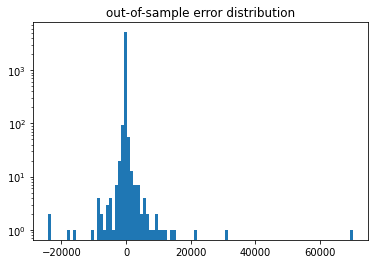

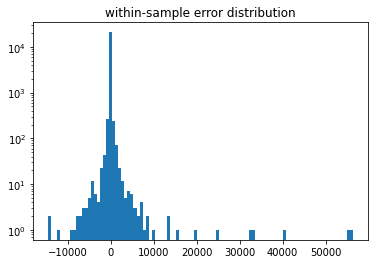

In [23]:
plt_error_hist(forest_opt)

# Gradient Booster

test R2: 0.7437957469661448
train R2: 0.9357488921897997


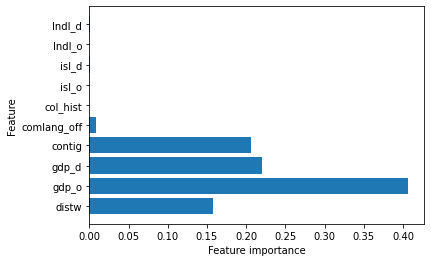

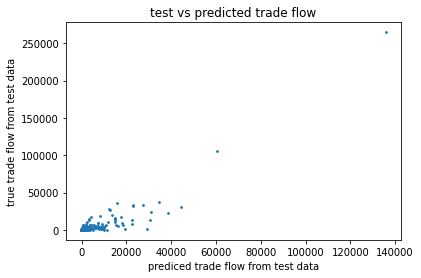

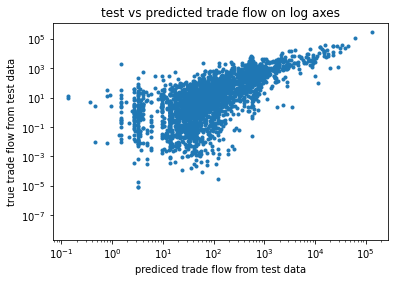

In [21]:
data.tts()
booster = GradientBoostingRegressor(random_state=7)
booster.fit(data.X_train, data.y_train)

get_R2s(booster)
plt_y_pred(booster)

grid search for the gradient booster

In [25]:
# loss
loss = ['ls', 'lad', 'huber', 'quantile']
# loss = ['ls', 'huber', 'quantile']
# learning rate
lr = [0.001, 0.01, 0.1, 1]
# subsample below 1 leads to stochastic gradient boosting 
subs = [0.5, 0.8, 1.0]
# max depth
maxD = [2, 3, 5]

# create the random grid
random_grid = {'loss': loss
               , 'learning_rate': lr
               #, 'subsample': subs
               , 'max_depth': maxD
               }

# base model to tune
baseBoost = GradientBoostingRegressor()

# random grid search for parameters
boost_random = RandomizedSearchCV(estimator = baseBoost
                                  , param_distributions = random_grid
                                  , n_iter =10           # different combinations to search
                                  , cv = 3              # 3 fold cross validation
                                  # , verbose=2
                                  #, random_state=42
                                  , n_jobs = -1         # use all available cores
                                  )

# if grid is to run on a different data split, run this:
data.tts(rnd = None)
# fixed data split:
# data.tts(rnd = 42)

# single grid search:
boost_random.fit(data.X_train, data.y_train)
boost_random.best_params_

{'learning_rate': 1, 'loss': 'huber', 'max_depth': 2}

In [26]:
booster_opt = GradientBoostingRegressor(learning_rate=0.1   
                                        , loss = 'ls'          
                                        , max_depth = 3         
                                        , n_estimators = 200
                                        )

rnd_val(booster_opt)

R2 test: 0.45532496155723046
R2 train 0.9489453514274889
R2 test: 0.8276302867178427
R2 train 0.9666227511709168
R2 test: 0.7749750085213584
R2 train 0.9600063915195177
R2 test: 0.7414109580724695
R2 train 0.9608117029202727
R2 test: 0.6437116325170633
R2 train 0.9716506593129769
R2 test: 0.26147225819536857
R2 train 0.9722984354924782
R2 test: 0.5833417401013898
R2 train 0.9707229168290276
R2 test: 0.5957244407646287
R2 train 0.9737825377457694
R2 test: 0.5647409813811375
R2 train 0.9708743797040242
R2 test: 0.8225887147335665
R2 train 0.9582614200217096
R2 test: 0.8560762069960499
R2 train 0.9692150417088923
R2 test: 0.414354337592323
R2 train 0.9714505353422418
R2 test: 0.7376485983280814
R2 train 0.97126487981723
R2 test: 0.7509028403331732
R2 train 0.966873511662962
R2 test: 0.8430194047811512
R2 train 0.9595001158319082
R2 test: 0.8126199030739486
R2 train 0.9694332960123512
R2 test: 0.7369656481934228
R2 train 0.9687745440861285
R2 test: 0.7640728904707291
R2 train 0.97129864676

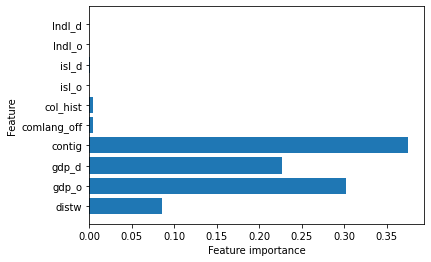

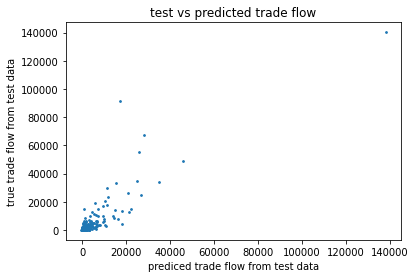

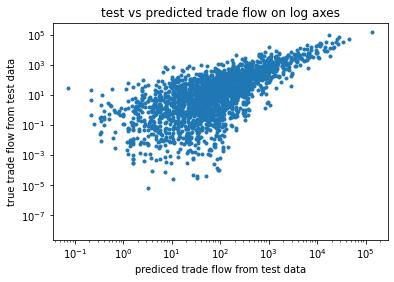

In [27]:
plt_y_pred(booster_opt)

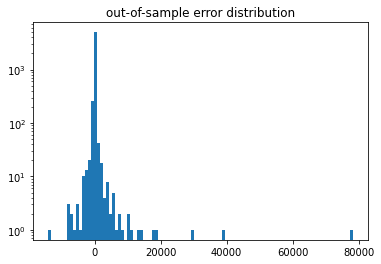

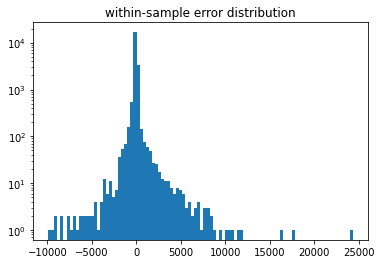

In [28]:
plt_error_hist(booster_opt)

## Boosting Stochastic Gradient Descent Regressor

test R2: 0.8227613040294448
train R2: 0.9941964384135061


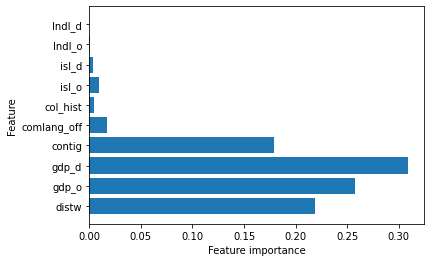

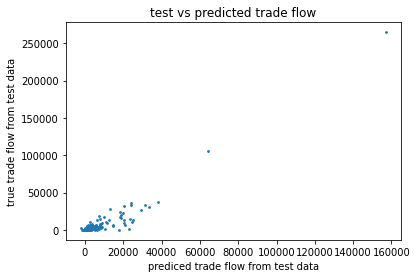

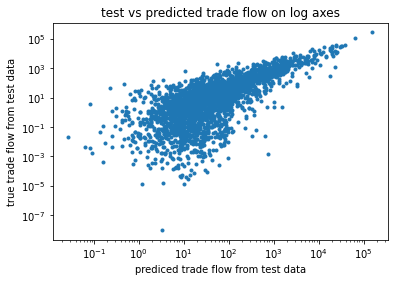

In [23]:
data.tts() 
booster_SGD = GradientBoostingRegressor(random_state=7
                                        , subsample = 0.8
                                        , max_depth=5       
                                        , n_estimators = 200
                                        )
     
booster_SGD.fit(data.X_train, data.y_train)

get_R2s(booster_SGD)
plt_y_pred(booster_SGD)

In [24]:
rnd_val(booster_SGD)

R2 test: 0.6641233197841312
R2 train 0.9959851146028258
R2 test: 0.6315204563567345
R2 train 0.9960360748164014
R2 test: 0.4188878822049101
R2 train 0.9957245812229953
R2 test: 0.7095766755634418
R2 train 0.995937939230531
R2 test: 0.5531821000428376
R2 train 0.9952584149081993
R2 test: 0.6257077348499334
R2 train 0.9961772701315087
R2 test: 0.7688191730897508
R2 train 0.9949681639924235
R2 test: 0.40580562844831214
R2 train 0.993914198032683
R2 test: 0.7902034142657723
R2 train 0.99525303025165
R2 test: 0.612812127379684
R2 train 0.9962329428056348
R2 test: 0.623914026599689
R2 train 0.9961496377230341
R2 test: 0.6388852740041783
R2 train 0.9960462475010537
R2 test: 0.897656574205465
R2 train 0.9953557611735993
R2 test: 0.738327560163436
R2 train 0.9955590017806063
R2 test: 0.4462473094541304
R2 train 0.9957641392458637
R2 test: 0.8843818056658543
R2 train 0.9955825706592459
R2 test: 0.74105467999712
R2 train 0.9960554347481884
R2 test: 0.8054090441001611
R2 train 0.995203203782179
R2

In [1]:
 plt_y_pred(booster_SGD)

NameError: ignored

# Ada Boost

R2 test: 0.7720140320477277
R2 train 0.999845591320093
R2 test: 0.7613657358130976
R2 train 0.9998252016615234
R2 test: 0.4654921654341452
R2 train 0.9997919341087038
R2 test: 0.6074327050860813
R2 train 0.9996988450002654
R2 test: 0.6862600090126787
R2 train 0.9998355468027271
R2 test: 0.6289399520927709
R2 train 0.9998635087296973
R2 test: 0.5063584326859327
R2 train 0.9997523409090079
R2 test: 0.6647369161697808
R2 train 0.9998886561196187
R2 test: 0.6636371837116386
R2 train 0.9997672634232047
R2 test: 0.5862216701655829
R2 train 0.9998589877884348
R2 test: 0.4510978881042581
R2 train 0.9998699136481037
R2 test: 0.3684965806863212
R2 train 0.9998950267074013
R2 test: 0.8688164414915849
R2 train 0.9997777604378442
R2 test: 0.8398432844370107
R2 train 0.9997380573245894
R2 test: 0.6172795400706976
R2 train 0.9997940008302589
R2 test: 0.4337418748889529
R2 train 0.9998753870041659
R2 test: 0.3713018627119685
R2 train 0.9999084789997402
R2 test: 0.6311538632942304
R2 train 0.9997948080

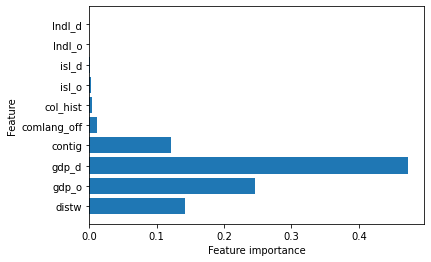

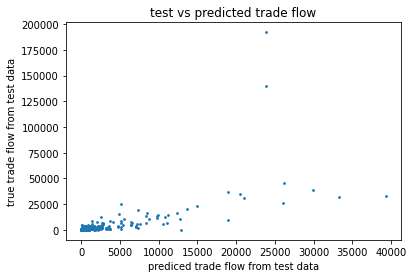

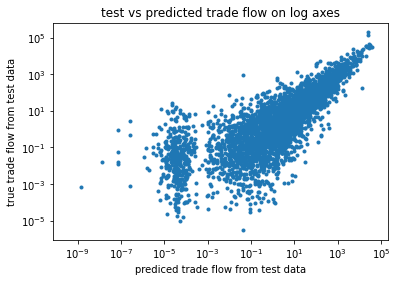

In [32]:
ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor())
rnd_val(ada)
plt_y_pred(ada)

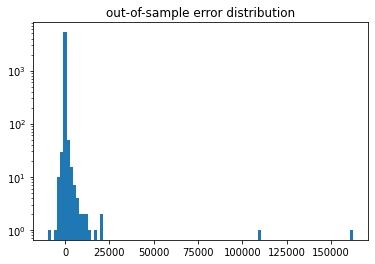

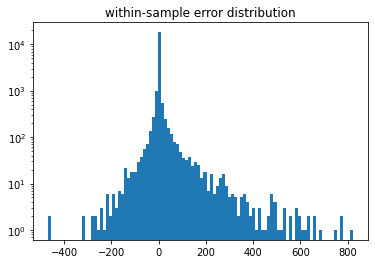

In [33]:
plt_error_hist(ada)